<a href="https://colab.research.google.com/github/miadibe/CASA0004/blob/master/01_FloorClassification_Fastai_Camera_5_Epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **FLOOR CLASSIFIER - SITE IMAGES**

In [ ]:
# Code Inspired by Luo, D. 2018: Classify Building Conditions in Zanzibar from Drone Imagery
# https://github.com/daveluo/zanzibar-aerial-mapping/blob/master/archive/znz-classify-buildings-20190118.ipynb
# and Fastai Image Classification
# https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb

**1- LOAD LIBRARIES**

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai import *
from fastai.vision import *

In [ ]:
from fastai.utils import *
show_install()



```text
=== Software === 
python        : 3.6.9
fastai        : 1.0.61
fastprogress  : 0.2.3
torch         : 1.5.1+cu101
nvidia driver : 418.67
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16280MB | Tesla P100-PCIE-16GB

=== Environment === 
platform      : Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Wed Feb 19 05:26:34 PST 2020
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once instal

**2- LOAD DATA CLONED FROM GITHUB PRIVATE REPO**

In [ ]:
u = 'username';
p = 'password'; 
!git clone https://$u:$p@github.com/$u/AEC-Demo.git

Cloning into 'AEC-Demo'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 4929 (delta 11), reused 20 (delta 6), pack-reused 4899
Receiving objects: 100% (4929/4929), 13.32 GiB | 41.52 MiB/s, done.
Resolving deltas: 100% (49/49), done.
Checking out files: 100% (5360/5360), done.


In [ ]:
path = Path('/content/AEC-Demo')

In [ ]:
path_img = path/'camera'

In [ ]:
fnames = get_image_files(path_img)
print(len(fnames))
fnames[:5]

4652


[PosixPath('/content/AEC-Demo/camera/2007150800200288_14-floors.jpg'),
 PosixPath('/content/AEC-Demo/camera/2003051145002027_10-floors.jpg'),
 PosixPath('/content/AEC-Demo/camera/2006171415008436_12-floors.jpg'),
 PosixPath('/content/AEC-Demo/camera/2007141950000210_14-floors.jpg'),
 PosixPath('/content/AEC-Demo/camera/1910301515004318_4-floors.jpg')]

**2- PREPROCESS DATA**

In [ ]:
# Filter out empty .jpg files by size>0 and sort
fnames = [fname.name for fname in sorted(fnames) if os.path.getsize(fname)>0]
print(len(fnames))
fnames[:5]

4652


['1810101155080695_0-floor.jpg',
 '1810101200000696_0-floor.jpg',
 '1810101215000697_0-floor.jpg',
 '1812251100005328_0-floor.jpg',
 '1812251115005329_0-floor.jpg']

In [ ]:
df = pd.DataFrame(fnames,columns=['fnames'])
df.head()

fnames
0  1810101155080695_0-floor.jpg
1  1810101200000696_0-floor.jpg
2  1810101215000697_0-floor.jpg
3  1812251100005328_0-floor.jpg
4  1812251115005329_0-floor.jpg

In [ ]:
# Hand-picked validation images
# Used for validation set which the model does not get to look at when training
# To avoid overfitting
holdout_grids = ['1810','1811','1812']
valid_idx = [i for i,o in df.iterrows() if any(c in str(o.fnames) for c in holdout_grids)]

In [ ]:
df.iloc[valid_idx].head()

fnames
0  1810101155080695_0-floor.jpg
1  1810101200000696_0-floor.jpg
2  1810101215000697_0-floor.jpg
3  1812251100005328_0-floor.jpg
4  1812251115005329_0-floor.jpg

**4- LABELS EXTRACTION**

In [ ]:
# Pulled out of fastai/data.py
# Use Python Regular expressions to retrieve labels out of filenames
pat = r'([^_]+).jpg$'
pat = re.compile(pat)
def get_label(fn): return pat.search(str(fn)).group(1)

In [ ]:
src = (ImageList.from_df(df, folder='camera', path=path)
        .split_by_idx(valid_idx)
        .label_from_func(get_label, classes=['0-floor', '1-floor', '2-floors', '3-floors',
                                             '4-floors','5-floors','6-floors','7-floors','8-floors',
                                             '9-floors','10-floors','11-floors','12-floors','13-floors',
                                             '14-floors','15-floors']))

In [ ]:
# Batch size: the higher the more accurate the model. 
# Start with 64 and reduce down to 2 if model throws GPU-related error
# It determines the number of image bunch to process at a time
bs = 16

# Image size: resize all images to 224 x 224 px and reduce down to 64 if model throws GPU-related error. 
sz = 64

# Data Augmentation: Flipping vertically, rotating, warpping, zooming, brightening
tfms = get_transforms(flip_vert=True, max_rotate=0.2, max_warp=0., max_zoom=1.1, max_lighting=0.4)

#Normalize all images to same mean and standard devation according to pretrained ImageNet (imagenet_stats) dataset
data = (src.transform(tfms, size=64, resize_method=ResizeMethod.SQUISH, padding_mode='zeros')
        .databunch(bs=bs)
        .normalize(imagenet_stats))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

In [ ]:
data

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

ImageDataBunch;

Train: LabelList (4550 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0-floor,0-floor,0-floor,0-floor,0-floor
Path: /content/AEC-Demo;

Valid: LabelList (102 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0-floor,0-floor,0-floor,0-floor,0-floor
Path: /content/AEC-Demo;

Test: None

In [ ]:
data.train_ds.classes

['0-floor',
 '1-floor',
 '2-floors',
 '3-floors',
 '4-floors',
 '5-floors',
 '6-floors',
 '7-floors',
 '8-floors',
 '9-floors',
 '10-floors',
 '11-floors',
 '12-floors',
 '13-floors',
 '14-floors',
 '15-floors']

0-floor /content/AEC-Demo/camera/1810101155080695_0-floor.jpg


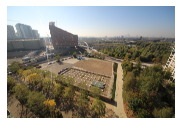

0-floor /content/AEC-Demo/camera/1810101200000696_0-floor.jpg


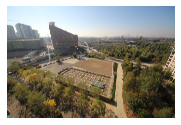

0-floor /content/AEC-Demo/camera/1810101215000697_0-floor.jpg


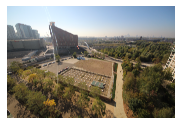

0-floor /content/AEC-Demo/camera/1812251100005328_0-floor.jpg


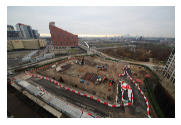

0-floor /content/AEC-Demo/camera/1812251115005329_0-floor.jpg


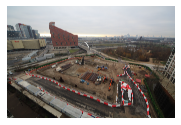

In [ ]:
# Show first 5 images
for i in range(5):
    print(data.valid_ds.classes[data.valid_ds.y[i].data], data.valid_ds.items[i]); 
    data.valid_ds.x[i].show()
    plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

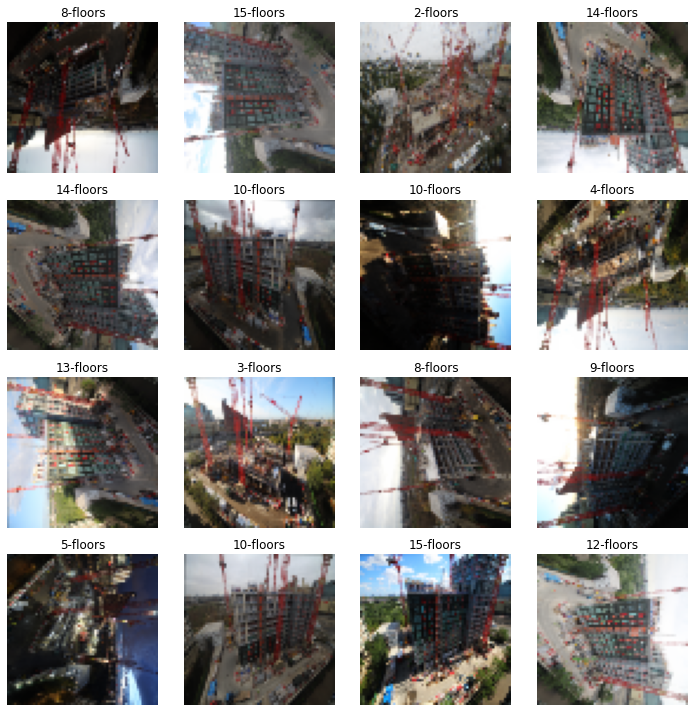

In [ ]:
#Show random images 
data.show_batch(rows=4, figsize=(10,10))

In [ ]:
# Add this line to prevent future warning messages 
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

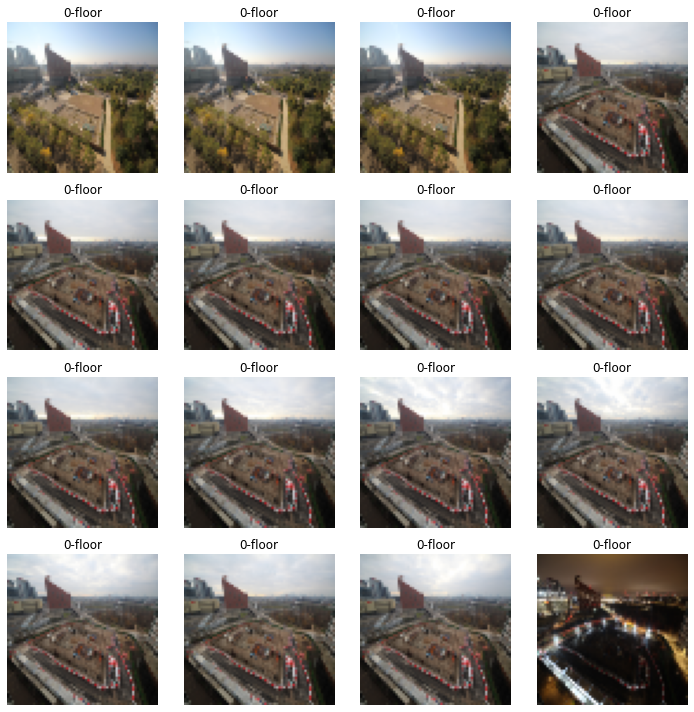

In [ ]:
data.show_batch(rows=4, figsize=(10,10), ds_type=DatasetType.Valid)

In [ ]:
# Cross Entropy Loss is the function for loss likelihood which penalises incorrect confident predictions and correct unconfident predictions (False positive & true negative)
data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [ ]:
#Create CNN model
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


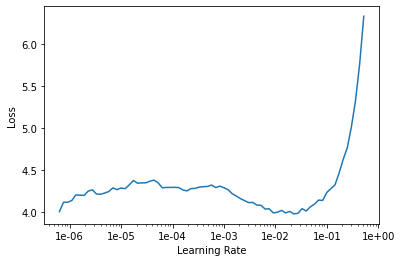

In [ ]:
#Learning rate indicates how quickly we are updating the model. By default, trains all layers at the same speed

learn.lr_find()
learn.recorder.plot()

In [ ]:
#Pick learning rate 
lr = 1e-3

In [ ]:
## IGNORE THIS and run next line

from fastai.callbacks import *

# small change to SaveModelCallback() to add printouts
@dataclass
class SaveModelCallbackVerbose(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    every:str='improvement'
    name:str='bestmodel'
    def __post_init__(self):
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
        super().__post_init__()

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                self.learn.save(f'{self.name}')
                print(f'saved model at epoch {epoch} with {self.monitor} value: {current}')

    def on_train_end(self, **kwargs):
        if self.every=="improvement": self.learn.load(f'{self.name}')

In [ ]:
#!pip install -q git+https://github.com/fastai/fastprogress --upgrade
#!pip install -q git+https://github.com/fastai/fastcore --upgrade
#!pip install -q git+https://github.com/fastai/fastai2 --upgrade

In [ ]:
#Run this line. Function that saves best model accuracy during training

class SaveBestModel(Recorder):
    def __init__(self, learn,name='best_model'):
        super().__init__(learn)
        self.name = name
        self.best_loss = None
        self.best_acc = None
        self.save_method = self.save_when_acc
        
    def save_when_acc(self, metrics):        
        loss, acc = metrics[0], metrics[1]
        if self.best_acc == None or acc > self.best_acc:
            self.best_acc = acc
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Save the best accuracy {:.5f}".format(self.best_acc))
        elif acc == self.best_acc and  loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Accuracy is eq,Save the lower loss {:.5f}".format(self.best_loss))
            
    def on_epoch_end(self,last_metrics=MetricsList,**kwargs:Any):
        self.save_method(last_metrics)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy, callback_fns=SaveBestModel)

In [ ]:
# Ignore this. Only run if getting "Image truncated" error (likely if not enough GPU memory to process all image)

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

if img and img.meta_type == 'Image':
    pilImg = PIL.Image.open( StringIO(str(img.data)) )
elif imgData:
    pilImg = PIL.Image.open( StringIO(imgData) )

try:
    pilImg.load()
except IOError:
    pass # You can always log it to logger

pilImg.thumbnail((width, height), PIL.Image.ANTIALIAS)

In [ ]:
# Train model for 10 epochs. Decrease this number if computing time is too slow. 

learn.fit_one_cycle(5, max_lr=lr)

Save the best accuracy 0.57843
Save the best accuracy 0.67647
Save the best accuracy 0.87255


In [ ]:
#learn.fit_one_cycle(10, max_lr=lr, callbacks=[SaveModelCallbackVerbose(learn,monitor='error_rate',mode='min',name='20181206-rn50class-stage1-best')])

In [ ]:
# Unfreeze() method trains the whole model, a way to fine-tuning the results above
# Freezing does not update the model accuracy (only the new layers), is faster in computing and uses less memory

learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
# Stage 2 of Training
# Use best saved model from above and slice learning rate to choose learning rate that is equally spread between first and last CNN layer
learn = cnn_learner(data, models.resnet50, metrics=accuracy, callback_fns=SaveBestModel)
learn.fit_one_cycle(5, max_lr=slice(3e-5,lr/5))

Save the best accuracy 0.52941


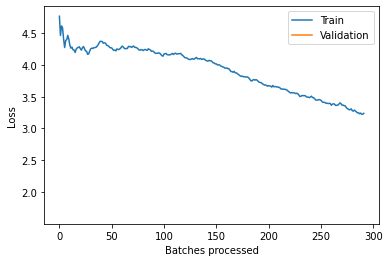

In [ ]:
learn.recorder.plot_losses()

**4- LOOK AT RESULTS**

In [ ]:
# What comes out of the training
interp = ClassificationInterpretation.from_learner(learn)

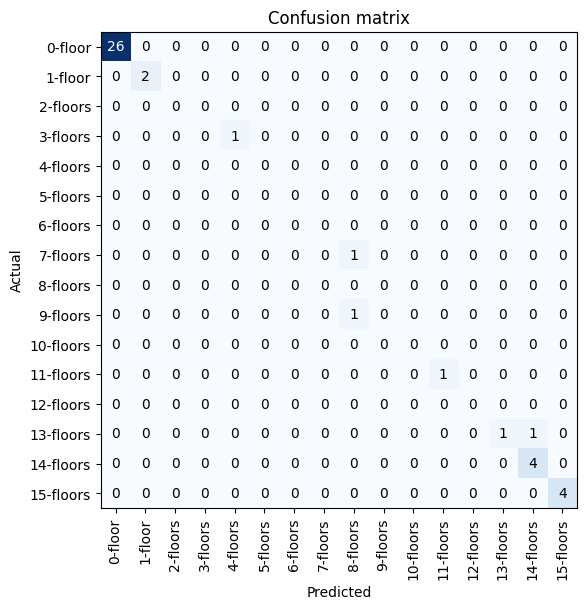

In [ ]:
# How many floors were predicted wrong
interp.plot_confusion_matrix(figsize=(6,6), dpi=100)

In [ ]:
# ('Should have predicted', 'predicted instead', 'how many times')
interp.most_confused(min_val=2)

[('12-floors', '13-floors', 10),
 ('15-floors', '12-floors', 7),
 ('15-floors', '14-floors', 6),
 ('0-floor', '1-floor', 4),
 ('6-floors', '5-floors', 4),
 ('15-floors', '10-floors', 3),
 ('15-floors', '13-floors', 3),
 ('0-floor', '7-floors', 2)]

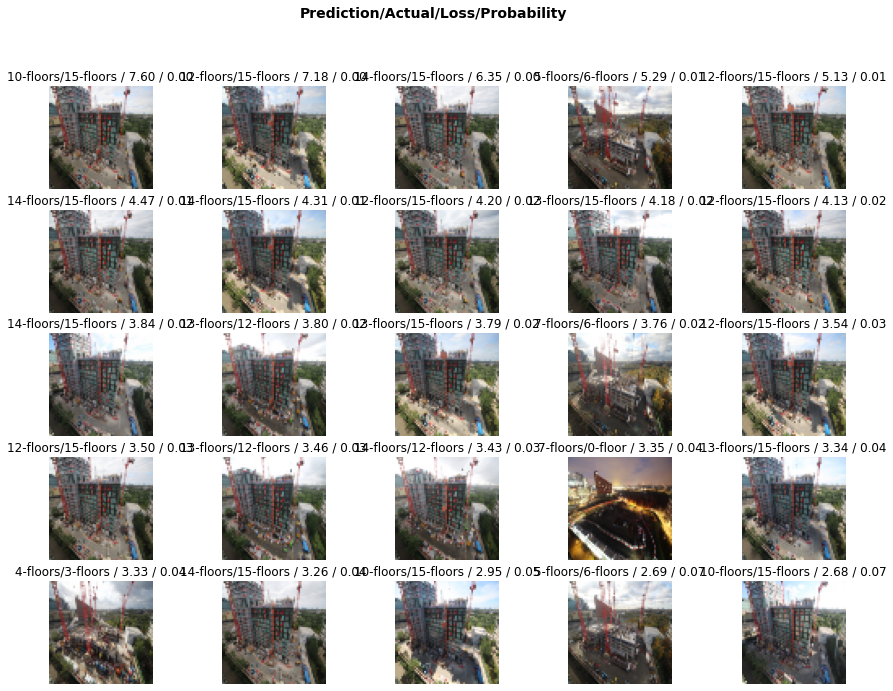

In [ ]:
# Tells how good the prediction was for 25 images
predactual = interp.plot_top_losses(25, figsize=(15,11))

**5- TEST TIME !**

In [ ]:
data.classes

['0-floor',
 '1-floor',
 '2-floors',
 '3-floors',
 '4-floors',
 '5-floors',
 '6-floors',
 '7-floors',
 '8-floors',
 '9-floors',
 '10-floors',
 '11-floors',
 '12-floors',
 '13-floors',
 '14-floors',
 '15-floors']

In [ ]:
#Reveal CNN Architecture 
learn.model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [ ]:
#Print number of test images 

test_path = Path(f'/content/AEC-Demo/test/test_camera')
test_fns = [o for o in sorted(test_path.iterdir()) if '.jpg' in o.name]
print(len(test_fns))

16


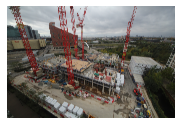

In [ ]:
img = open_image(test_fns[10])
img.show()
plt.show()

In [ ]:
#Tensor array for pixels prediction 
learn.predict(img)

(Category tensor(3),
 tensor(3),
 tensor([0.0020, 0.0063, 0.0285, 0.6074, 0.1251, 0.0134, 0.0763, 0.0012, 0.0075,
         0.0071, 0.0349, 0.0140, 0.0249, 0.0072, 0.0374, 0.0070]))

In [ ]:
from tqdm import tqdm

In [ ]:
preds = []
pred_classes = []
for fn in tqdm(test_fns):
    try: 
        img = open_image(fn)
        img = img.apply_tfms(tfms[1],resize_method=ResizeMethod.SQUISH, padding_mode='zeros')
        pred_class,pred_idx,outputs = learn.predict(img)
        preds.append(list(to_np(outputs)))
        pred_classes.append(str(pred_class))
    except Exception as exc: 
        print(f'{exc}') 
        preds.append([-1,-1,-1,-1])
        pred_classes.append('error')

100%|██████████| 16/16 [00:09<00:00,  1.74it/s]


In [ ]:
np.round(preds,2)

array([[0.36, 0.2 , 0.01, 0.06, ..., 0.03, 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , ..., 0.01, 0.  , 0.03, 0.  ],
       [0.  , 0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  , 0.01],
       [0.  , 0.01, 0.  , 0.  , ..., 0.2 , 0.01, 0.09, 0.02],
       ...,
       [0.01, 0.01, 0.02, 0.08, ..., 0.  , 0.  , 0.06, 0.  ],
       [0.01, 0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.02, 0.  ],
       [0.  , 0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.03, 0.  ],
       [0.  , 0.13, 0.05, 0.03, ..., 0.08, 0.01, 0.02, 0.02]], dtype=float32)

In [ ]:
df = pd.DataFrame(data=preds, columns=data.classes)
df['fname'] = [o.name for o in test_fns[:len(preds)]]
df['predicted_class'] = pred_classes

In [ ]:
#Print Confidence level (probabilities)
df.head(16)

0-floor   1-floor  2-floors  ...  15-floors           fname  predicted_class
0   0.360291  0.204787  0.008551  ...   0.003785   example0f.jpg          0-floor
1   0.000122  0.000234  0.001658  ...   0.003978  example10f.jpg        10-floors
2   0.000452  0.001890  0.000087  ...   0.005261  example11f.jpg        10-floors
3   0.001846  0.005286  0.003353  ...   0.024093  example12f.jpg        11-floors
4   0.003249  0.013750  0.007761  ...   0.062985  example13f.jpg        13-floors
5   0.004216  0.015429  0.014797  ...   0.041585  example14f.jpg        13-floors
6   0.001046  0.000654  0.000858  ...   0.006077  example15f.jpg        13-floors
7   0.014553  0.479363  0.105671  ...   0.001907   example1f.jpg          1-floor
8   0.000897  0.000489  0.019438  ...   0.001440   example2f.jpg         3-floors
9   0.228527  0.022352  0.103044  ...   0.025431   example3f.jpg          0-floor
10  0.001968  0.006262  0.028471  ...   0.007000   example4f.jpg         3-floors
11  0.017652  0.001719  0.025356  ...   0.000034   example5f.jpg         5-floors
12  0.013323  0.008114  0.017347  ...   0.004878   example6f.jpg         5-floors
13  0.005615  0.000654  0.004691  ...   0.000172   example7f.jpg         5-floors
14  0.002103  0.003513  0.002024  ...   0.000253   example8f.jpg         5-floors
15  0.002042  0.126119  0.051046  ...   0.019816   example9f.jpg         6-floors

[16 rows x 18 columns]

In [ ]:
pred_classes[:5]

['0-floor', '10-floors', '10-floors', '11-floors', '13-floors']

0-floor category confidence: 0.36029064655303955


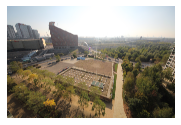

10-floors category confidence: 0.8961408734321594


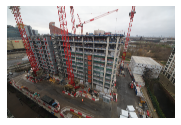

10-floors category confidence: 0.971275806427002


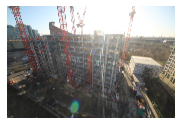

11-floors category confidence: 0.5909199714660645


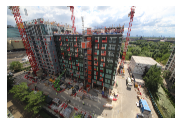

13-floors category confidence: 0.5052117705345154


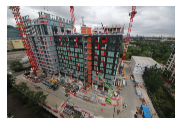

13-floors category confidence: 0.40845122933387756


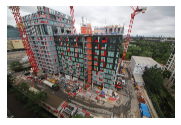

13-floors category confidence: 0.4330366253852844


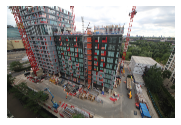

1-floor category confidence: 0.47936251759529114


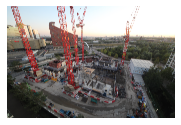

3-floors category confidence: 0.8927675485610962


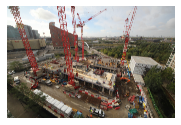

0-floor category confidence: 0.22852680087089539


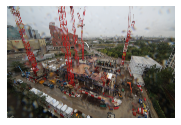

3-floors category confidence: 0.6073633432388306


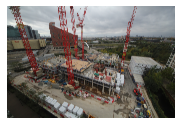

5-floors category confidence: 0.6890886425971985


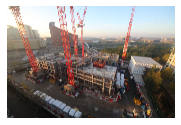

5-floors category confidence: 0.5211430788040161


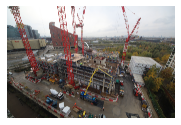

5-floors category confidence: 0.9365094304084778


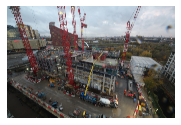

5-floors category confidence: 0.7531500458717346


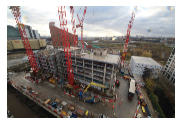

6-floors category confidence: 0.3310298025608063


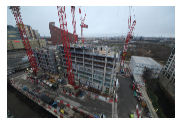

In [ ]:
# Show results for 16 images 
for i in range(16):
    img = open_image(test_path/df.iloc[i]['fname'])
    print(df.iloc[i]['predicted_class'], 'category confidence:', df[df.iloc[i]['predicted_class']].iloc[i])
    img.show()
    plt.show()

In [ ]:
# Save outputs to .csv
df.to_csv('/content/outputs/20200728_camera_predictions01.csv',index=False)

**6- EXTRA: T-SNE VISUALISATION**

In [ ]:
# t-SNE Visualization (thanks to & adapted from @KarlH)
# https://forums.fast.ai/t/share-your-work-here/27676/53
# https://github.com/kheyer/ML-DL-Projects/blob/master/Pets%20TSNE/pets_tsne.ipynb

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn import manifold, datasets
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import squareform
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import NullFormatter
import PIL

In [ ]:
preds = interp.preds
y = interp.y_true
losses = interp.losses

In [ ]:
probs_trans = manifold.TSNE(n_components=2, perplexity=15).fit_transform(preds)

In [ ]:
prob_df = pd.DataFrame(np.concatenate((probs_trans, y[:,None]), axis=1), columns=['x','y','labels'])
prob_df.head()

x          y  labels
0  2.526772   3.007268     0.0
1  2.865052   3.001851     0.0
2  2.715906   2.499310     0.0
3 -3.465348  11.813476     0.0
4 -5.826923  15.267513     0.0

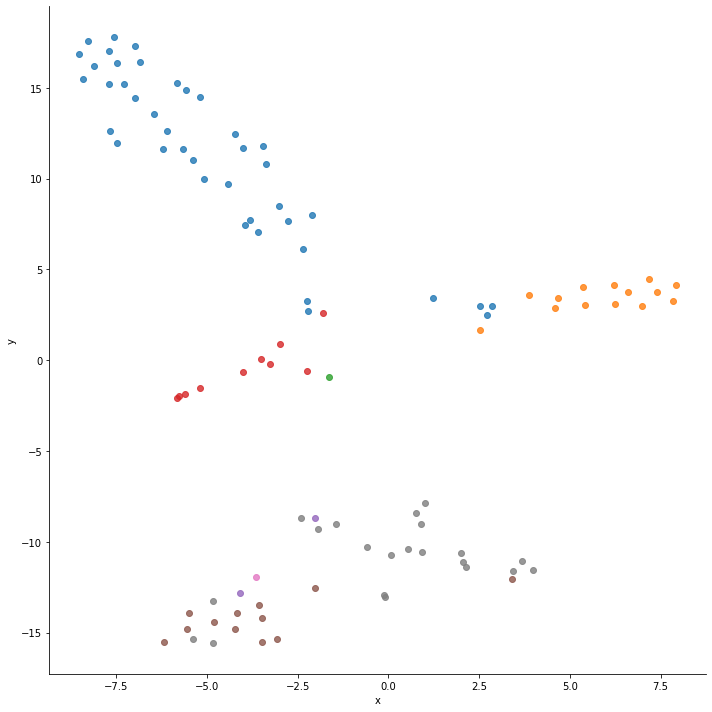

In [ ]:
#Visualise top losses 
g = sns.lmplot('x', 'y', data=prob_df, hue='labels', fit_reg=False, legend=False, height=10)

In [ ]:
prob_df['fname'] = data.valid_ds.items
prob_df['loss'] = losses
prob_df.head()

x  ...      loss
0  2.526772  ...  1.780129
1  2.865052  ...  1.894542
2  2.715906  ...  2.032535
3 -3.465348  ...  0.338525
4 -5.826923  ...  0.124047

[5 rows x 5 columns]

In [ ]:
#Export outputs to .csv
prob_df.to_csv('/content/outputs/t-SNE.csv')

In [ ]:
# modified to optionally filter by idxs

def visualize_scatter_with_images(scaled_data, df, idxs, figsize=(64,64), image_zoom=1, suffix=1):
    scaled_data = scaled_data[idxs]
    df = df.iloc[idxs]

    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    xx = (scaled_data[:,0])
    yy = (scaled_data[:,1])
    
    for (i,x,y) in zip(idxs,xx,yy):
        im = PIL.Image.open(df['fname'][i])
        im.thumbnail((64,64))
        img = OffsetImage(im, zoom=image_zoom, cmap='gray')
        ab = AnnotationBbox(img, (x, y), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([xx,yy]))
    ax.autoscale()
    
#     fig.savefig(f'TSNE_{suffix}.jpg', bbox_inches = 'tight')
    return fig, ax

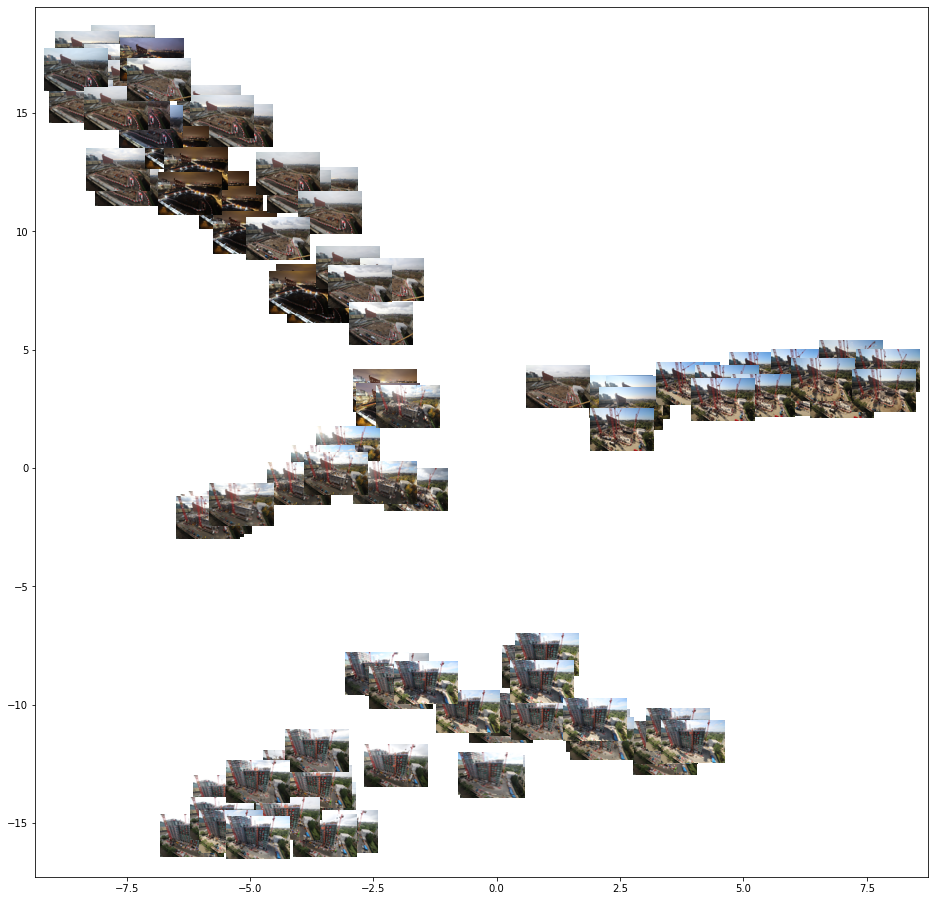

In [ ]:
fig, ax = visualize_scatter_with_images(probs_trans, prob_df, range(len(prob_df)), figsize=(16,16), image_zoom=1, suffix='probabilities')
plt.show()

In [ ]:
top_losses = prob_df['loss'].sort_values(ascending=False)[:20].index.values

In [ ]:
toplossdf = prob_df.iloc[top_losses]
toplossdf

x  ...      loss
83  -1.933611  ...  7.600372
92   3.679298  ...  7.179091
85  -0.095428  ...  6.352395
63  -5.843110  ...  5.290316
91   2.142246  ...  5.128394
86   0.077515  ...  4.465787
95  -0.584023  ...  4.305015
87   3.426859  ...  4.196719
81  -4.846063  ...  4.179800
84   2.049635  ...  4.126009
101 -0.127082  ...  3.836488
73  -5.513209  ...  3.800586
93  -5.393926  ...  3.786894
64  -1.805503  ...  3.756394
94   3.970533  ...  3.536146
90   0.927651  ...  3.496715
74  -6.176478  ...  3.458861
70  -2.033427  ...  3.425532
25  -2.210752  ...  3.347453
96  -4.848210  ...  3.338431

[20 rows x 5 columns]

In [ ]:
toplossdf.to_csv('/content/outputs/top20-losses.csv')

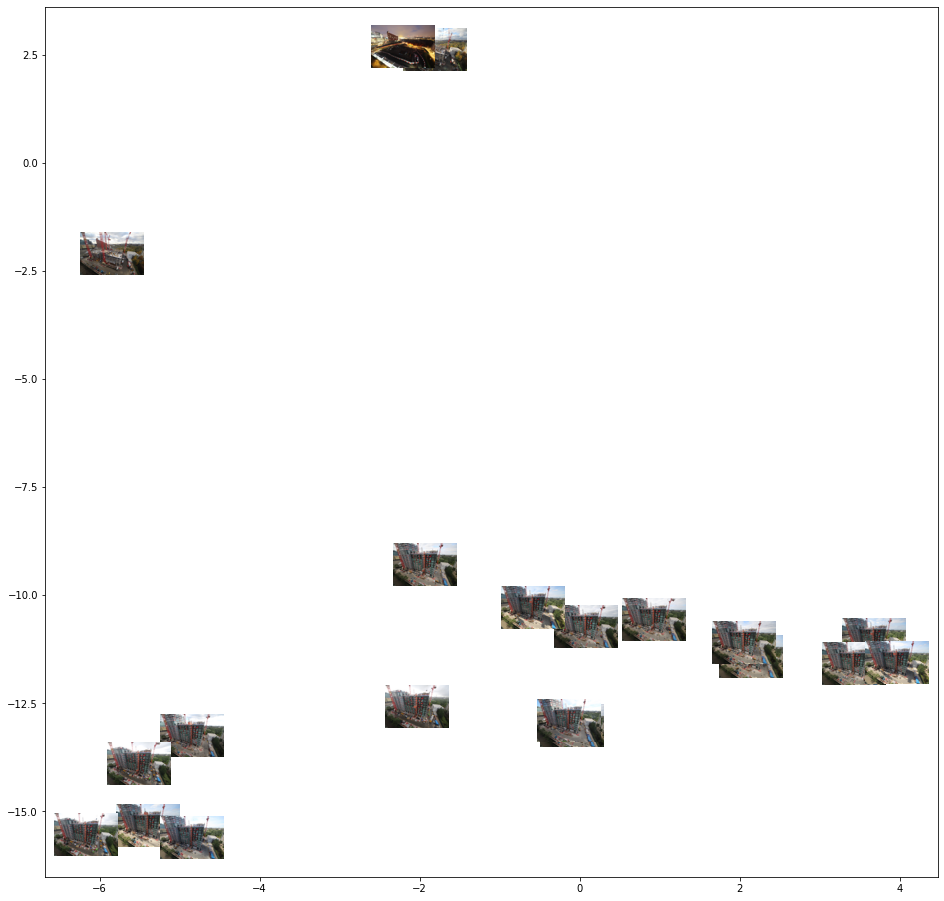

In [ ]:
# Show only images with top 20 losses
fig, ax = visualize_scatter_with_images(probs_trans, prob_df, top_losses, figsize=(16,16),image_zoom=1, suffix='probabilities')
plt.show()

In [ ]:
# Grad-CAM based on lesson6-pets-more

m = learn.model.eval()

Category 0

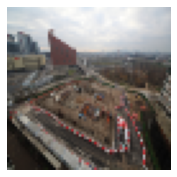

In [ ]:
idx = 12
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [ ]:
xb, yb = data.one_item(x) # make batch with one item
xb_im = Image(data.denorm(xb)[0]) # denorm item into viewable image
xb = xb.cuda() # load on gpu

(None, torch.Size([1, 3, 64, 64]), torch.Size([1]))

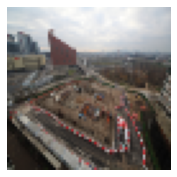

In [ ]:
xb_im.show(), xb.shape, yb.shape

In [ ]:
y, yb

(Category 0, tensor([0], device='cuda:0'))

In [ ]:
from fastai.callbacks.hooks import *
import pdb

In [ ]:
def hooked_backward(cat=y):
#     pdb.set_trace()
    with hook_output(m[0]) as hook_a: # set activation hook
        with hook_output(m[0], grad=True) as hook_g: # set gradient hook
            preds = m(xb) # forward pass
            preds[0,int(cat)].backward() # backward pass
    return hook_a, hook_g

In [ ]:
hook_a, hook_g = hooked_backward()

In [ ]:
acts = hook_a.stored[0].cpu()

In [ ]:
acts.shape

torch.Size([2048, 2, 2])

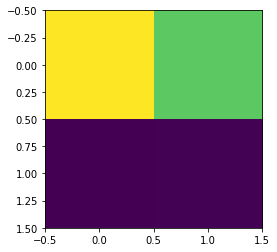

In [ ]:
plt.imshow(acts[0])

In [ ]:
avg_acts = acts.mean(0) # get the "pixel"-wise mean of activations (avg across 2018 channels)
avg_acts.shape

torch.Size([2, 2])

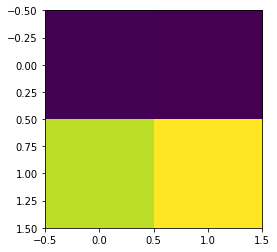

In [ ]:
plt.imshow(avg_acts)

In [ ]:
grad = hook_g.stored[0][0].cpu()

In [ ]:
grad.shape

torch.Size([2048, 2, 2])

In [ ]:
grad_chan = grad.mean(1).mean(1) # get the avg of grads for each channel
grad.shape, grad_chan.shape

(torch.Size([2048, 2, 2]), torch.Size([2048]))

In [ ]:
grad_chan[...,None,None].shape # make 2 more axes to be same shape as acts

torch.Size([2048, 1, 1])

In [ ]:
(acts*grad_chan[...,None,None]).mean(0).shape

torch.Size([2, 2])

In [ ]:
mult = (acts*grad_chan[...,None,None]).mean(0)


In [ ]:
def show_heatmap(hm,interpol='bilinear',cmap='magma'):
    _, ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,512,512,0), interpolation=interpol,cmap=cmap)

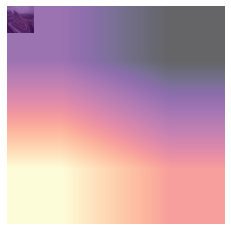

In [ ]:
show_heatmap(mult)

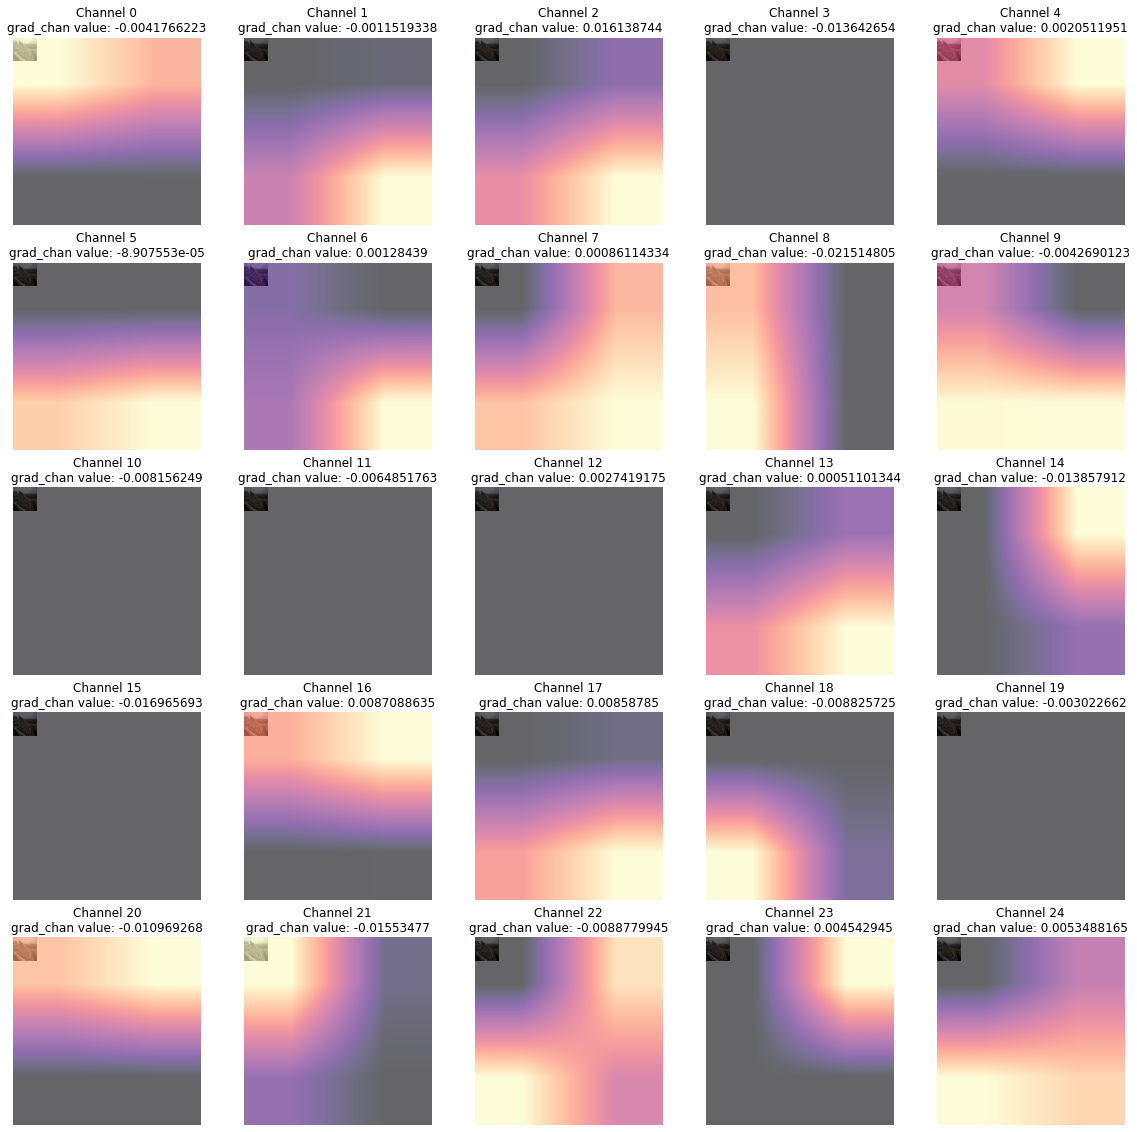

In [ ]:
fig, axes = plt.subplots(5,5, figsize=(20,20))
for j, ax in enumerate(axes.flat):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    xb_im.show(ax=ax)
    ax.set_title('Channel '+str(j)+ '\n'+'grad_chan value: '+str(grad_chan.numpy()[j]))
    ax.imshow(acts[j], alpha=0.6, extent=(0,512,512,0), interpolation='bilinear',cmap='magma')
#     ax.imshow([importance_idxs[j]]), alpha=0.6)
plt.show()

In [ ]:
# thanks @henripal, from https://github.com/henripal/maps/blob/master/nbs/big_resnet50-interpret-gradcam-dogs.ipynb
import scipy.ndimage

def upsample(heatmap, zoom=32):
    upsampled = scipy.ndimage.zoom(heatmap, zoom)
    upsampled = (upsampled - np.min(upsampled))/((np.max(upsampled) - np.min(upsampled))+1e-16)
    return upsampled

In [ ]:
grad_df = pd.DataFrame(grad_chan.numpy(), columns=['grad_chan'])
grad_df.head()

grad_chan
0  -0.004177
1  -0.001152
2   0.016139
3  -0.013643
4   0.002051

In [ ]:
importance_idxs = grad_df.sort_values(by='grad_chan',ascending=False).index.values
importance_idxs

array([ 310, 1163,  897, 1690, ..., 1303, 2015, 1076,  492])

In [ ]:
grad_df.iloc[importance_idxs].head()

grad_chan
310    0.048013
1163   0.045796
897    0.042541
1690   0.040338
1040   0.039953

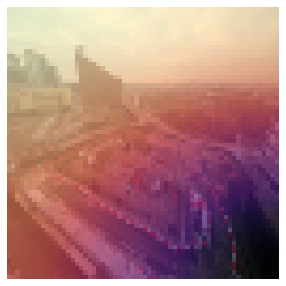

In [ ]:
# heatmap with most important 100 activations (ranked by grad_chan)
fm_up = [upsample(fm) for fm in acts[importance_idxs[:100]]]
xb_im.show(figsize=(5,5))
plt.imshow(np.mean(fm_up, axis=0),alpha=0.6, cmap='magma')

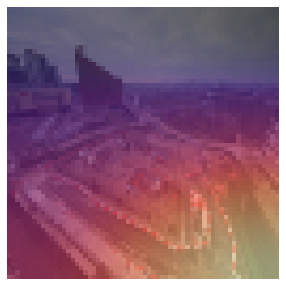

In [ ]:
# heatmap with least important 100 activations (ranked by grad_chan)
fm_up = [upsample(fm) for fm in acts[importance_idxs[-100:]]]
xb_im.show(figsize=(5,5))
plt.imshow(np.mean(fm_up, axis=0),alpha=0.6, cmap='magma')

In [ ]:
tfms = get_transforms(flip_vert=True, max_rotate=0.2, max_warp=0., max_zoom=1.1, max_lighting=0.4)

In [ ]:
## end